# Apprentissage fédéré 

## Objectifs

Nous allons implémenter l'algorithme FedAvg qui a été proposer par [1] et qui a formaliser le concept d'apprentissage fédéré. Nous allons ensuite voir quels effets ont certains paramètres de l'algorithme.

Par la suite, nous allons simuler un type d'attaque : les attaques byzantines. Il s'agira de voir dans quelle mesure ces attaques dégradent les modèles.

## Bibliographie

[1](https://proceedings.mlr.press/v54/mcmahan17a.html) Brendan McMahan, H., Moore, E., Ramage, D., Hampson, S., &#38; Agüera y Arcas, B. (2017). Communication-efficient learning of deep networks from decentralized data. <i>Proceedings of the 20th International Conference on Artificial Intelligence and Statistics, AISTATS 2017</i>, <i>54</i>.

## Librairies python

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import random
import time

## Données

Pour entrainer nos modèles (et les attaquer) nous allons utiliser la base MNIST. Il s’agit d’une base de données de chiffres de 0 à 9 écrits à la main qui est devenue un test standard notamment pour constituer des benchmarks.
Nous allons procéder à une analyse rapide de cette base.

Les données sont séparées en deux sets : un set d’entraînement qui nous servira à produire des modèles et un set de test qui servira à connaître les performances des modèles obtenus.

Vous pouvez accéder aux images et aux labels grâce aux attributs `.data` et `.targets` respectivement.

In [2]:
# MNIST : charger les données
# //!\\ il faut créer un dossier data dans le répertoire contenant ce notebook pour pouvoir télécharger les données
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),]))
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),]))

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...


C:\Users\FE264791\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


## Apprentissage fédéré

Nous nous plaçons maintenant dans un contexte fédéré. Pour simuler cela, nous allons diviser les données en $n$ clients grâce à la fonction `KFold`. Cette fonction nous permettra de séparer les indices des données en $n$ groupes (splits) qui correspondront aux clients. Nous garderons ces indices dans un dictionnaire où les clés seront les id des clients et les valeurs les indices des données appartenant au client corespondant.

Vous pouvez prendre $n=100$

In [3]:
n = 100
clients_train_samples = {}

# Données d'entraînement
for i, idx in enumerate(KFold(n_splits=n, shuffle=True).split(mnist_train)):
    clients_train_samples[i] = idx[1]
    
for i in range(n):
    print("Dataset du client {}: entraînement {} ".format(str(i), clients_train_samples[i].shape[0]))

Dataset du client 0: entraînement 600 
Dataset du client 1: entraînement 600 
Dataset du client 2: entraînement 600 
Dataset du client 3: entraînement 600 
Dataset du client 4: entraînement 600 
Dataset du client 5: entraînement 600 
Dataset du client 6: entraînement 600 
Dataset du client 7: entraînement 600 
Dataset du client 8: entraînement 600 
Dataset du client 9: entraînement 600 
Dataset du client 10: entraînement 600 
Dataset du client 11: entraînement 600 
Dataset du client 12: entraînement 600 
Dataset du client 13: entraînement 600 
Dataset du client 14: entraînement 600 
Dataset du client 15: entraînement 600 
Dataset du client 16: entraînement 600 
Dataset du client 17: entraînement 600 
Dataset du client 18: entraînement 600 
Dataset du client 19: entraînement 600 
Dataset du client 20: entraînement 600 
Dataset du client 21: entraînement 600 
Dataset du client 22: entraînement 600 
Dataset du client 23: entraînement 600 
Dataset du client 24: entraînement 600 
Dataset du

In [5]:
clients_train_samples[1]

array([   66,    90,   328,   339,   352,   378,   420,   480,   493,
         652,   739,   930,   943,   966,  1011,  1171,  1342,  1413,
        1477,  1840,  1932,  2201,  2265,  2290,  2382,  2416,  2517,
        2638,  2641,  2656,  2683,  2685,  2842,  3164,  3200,  3270,
        3520,  3603,  3696,  3852,  3995,  4365,  4384,  4440,  4493,
        4521,  4689,  4775,  5012,  5032,  5076,  5571,  5581,  5730,
        5757,  5791,  5912,  6005,  6022,  6024,  6177,  6478,  6576,
        6708,  6725,  6867,  6965,  6967,  7071,  7112,  7396,  7587,
        7843,  7904,  8052,  8102,  8298,  8301,  8459,  8474,  8479,
        8576,  8606,  8733,  8764,  8982,  9026,  9163,  9246,  9285,
        9337,  9499,  9565,  9708,  9877, 10010, 10383, 10448, 10523,
       10898, 10933, 10943, 10950, 10960, 11217, 11316, 11351, 11395,
       11406, 11713, 11891, 11968, 12092, 12283, 12433, 12516, 12564,
       12746, 12857, 12865, 13114, 13361, 13525, 13682, 13773, 13886,
       14148, 14190,

Nous definissions ensuite l'architecture du modèle de chaque client. Il s'agit d'un modèle assez simple et avec peu de paramètres pour faciliter l'entraînement dans le cadre du TP.

Nous allons utiliser le framework de deep learning `Pytorch` pour construire nos modèles. Voici quelques fonctions utiles pour le TP:
* state_dict() : lorsque vous instanciez un modèle (de la classe `nn.Module`) `n=Net()`, vous pouvez accéder aux poids avec `n.state_dict()`. Il s'agira d'un dictionnaire dont les clés sont le nom des poids et les valeurs les poids.
* load_state_dict() : vous pouvez également assigner des nouveaux poids à un réseau grâce à un dictionnaire de même architecture avec `n.load_state_dict(new_weights)`
* Vous trouverez des optimiseurs classiques dans la classe `torch.optim.`. Pour réaliser une descente de gradient, vous pouvez par exemple utiliser `torch.optim.SGD(net.parameters(), lr=0.01)` où `net.parameters()` dont les paramètres du réseau que vous voulez optimiser avec un taux d'apprentissage de $0.01$
* La fonction `.zero_grad()` d'une instanciation d'un optimiseur permet de "mettre à zero" les gradients de celui-ci. Avant chaque itération d'optimisation il faut l'appeler pour ne pas accumuler les gradients.
* Pour obtenir la sortie d'un réseau `net` des entrées `data`, il suffit d'appeler `net(data)`.
* Pour effectuer un entraînement il faut définir une fonction de perte. Avec le réseau que nous allons définir et vu qu'on est dans un problème de classification, vous pouvez utiliser la fonction de vraissemblance négative `F.nll_loss`.
* Pour calculer les gradients par rapport aux poids d'une instanciation de fonction de perte `loss`, vous pouvez appeler `loss.backward()`.
* Un optimiseur `optimizer` effectuera une mise à jour en appelant `optimizer.step()`.

In [10]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Nous allons maintenant écrire l'algorithme `FedAvg`. En se reférant à [1], le pseudo-code est :  
<img src="Capture3.png" width="400" height="200">

Cette fonction aura pour paramètres:
* C : le pourcentage de clients échantillonés à chaque round
* rounds : le nombre de rounds
* E : le nombre d'epochs local
* B : la taille des mini-batch locaux

Pour l'instant, nous voulons uniquement écrire la dynamique fédérée qui se compose en 4 grandes parties :
1. Le serveur initialize un modèle et l'envoie aux clients.
2. Les clients reçoient le modèle et font un entraînement local chacun séparement.
3. Chaque client envoie au serveur les poids de son modèle ainsi que le nombre de données locales.
4. Le serveur fait ensuite une moyenne des poids pondérée par rapport au nombre de données locales. Il renvoie ensuite cette moyenne aux clients qui reprenent à l'étape (2). C'est le début d'un autre round.

Nous allons écrire séparément une fonction `client_update` qui permettra de faire l'entraînement local.

In [18]:
def fed_avg(C, rounds, E, B):
    # Variable pour mesurer le temps d'entraînement
    t = time.time()
    
    # Initialisation
    global_model = Net()
    global_model_dict = global_model.state_dict()
    
    # Commencer l'entraînement par rounds
    for r in range(rounds) :
        # Dictionnaire dont les clés sont les mêmes que celles de global_model 
        # et les valeurs sont des matrices nulles de mêmes taille que celles de global model.
        global_model_update = {k:torch.zeros_like(v) for k,v in global_model.state_dict().items()}
        
        # Selectionner des identifiants de clients aléatoirement. Vous pouvez utiliser random.sample
        
        
        # Stocker le nombre de données des clients
        clients_nks = []
        
        for client_id in selected:
            # Envoyez le modèle au client
            
            
            # Entraînement local du client. La fonction client_update peut être écrite à part, dans une autre cellule
            nk, client_model = client_update(client_id, client_net, E, B)
            
            # Envoyer les poids et le nombre de données au serveur
            clients_nks += [nk]
            for w in global_model_update.keys():
                global_model_update[w] += nk*client_model[w]
        
        # Faire la moyenne pondérée des poids reçus
        
        
        # Définir la moyenne comme le nouveau modèle
        global_model.load_state_dict(global_model_update)
        
    
    print("Temps d'entraînement total: {}".format(time.time()-t))

    return accuracy

Nous pouvons écrire une fonction `client_update` à part qui permettra de faire l'entraînement local par client. Le choix est libre, mais elle peut prendre comme arguments :
* client_id : l'identifiant du client
* client_net : le réseau que le client optimisera localement
* E, B : les paramètres locaux de FedAvg

La fonction devra retourner le nombre de données `nk`et le dictionnaire des poids du client.

In [6]:
def client_update(client_id, client_net, E, B):
    
    # Compteur des données 
    nk = 0
    
    # Définir le nombre de batchs
    nb_batch = np.ceil(clients_train_samples[client_id].shape[0]/B)
    
    for epoch in range(E):
        # Mélanger les indexes des données pour diminuer le biais de l'entraînement
        random.shuffle(clients_train_samples[client_id])
        
        # Parcourir les données par batch
        for batch in range(int(nb_batch)):
            # Sélectionner les indices correspondant au batch courant
            indices =
            data = mnist_train.data[indices]
            labels = mnist_train.targets[indices]
            
            # Ajouter le nombre de données au compteur
            nk += 
            
            # Optimisation du modèle
            optimizer = 
            optimizer.zero_grad()
            
            output = 
            loss = 
            loss.backward()
            optimizer.step()
            
    return nk, client_net.state_dict()

Pour évaluer le modèle, il faut maintenat utiliser les données test. Etant donné que nous voulons construire un modèle global, nous devons évaluer le modèle pour tous les clients. Il n'est donc plus nécésaire de diviser les données test.

La fonction suivante calcule la précision de `model` par rapport à toutes les données test. Vous pouvez l'incorporer à la fonction `fed_avg` pour pouvoir évaluer le modèle à chaque round. 

In [53]:
def fed_avg_testing(model):
    with torch.no_grad():
        model.eval()
        outputs = model(mnist_test.data.unsqueeze(1).float())
        pred = torch.argmax(outputs.data, dim=1)
        correct = (pred == mnist_test.targets).sum().item()
    total = mnist_test.targets.shape[0]
    return correct / total

Nous pouvons maintenant jouer sur les paramètres de l'algorithme. Pour que l'entraînement ne soit pas très long, vous pouvez garder `C=0.1` et `rounds<20`. Vous pouvez tester différentes valeurs de `E` et `B` pour voir quels seraient des paramètres convenables. N'oubliez pas de prendre en compte le temps d'entraînement également. 

Temps d'entraînement total: 98.50118064880371
Temps d'entraînement total: 168.97805094718933
Temps d'entraînement total: 94.63739657402039
Temps d'entraînement total: 352.25719356536865


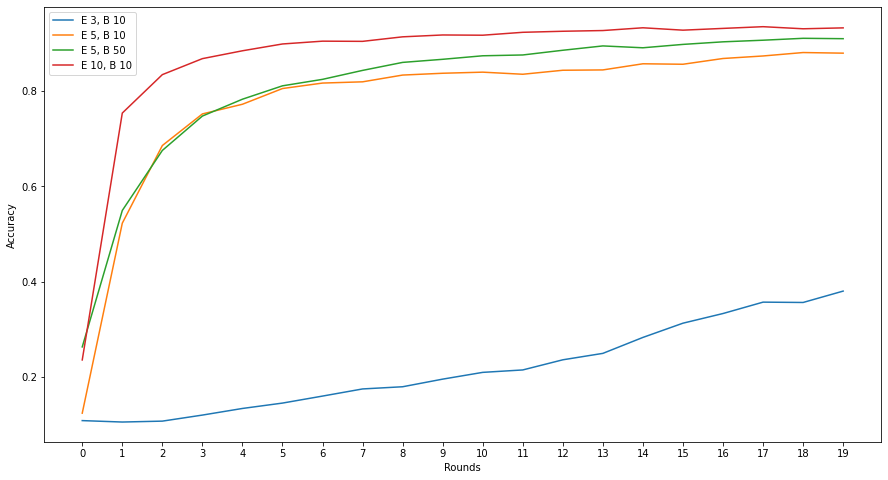

In [22]:
# Visualistion
rounds=20
Es = [3, 5, 5, 10]
Bs = [10, 10, 50, 10]
cnt = 0
plt.figure(figsize=(15,8))
for e,b in zip(Es,Bs):
    acc = fed_avg(C=0.1, rounds=rounds, E=e, B=b)
    plt.plot(acc, label='E {}, B {}'.format(e,b))
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.xticks(range(rounds), range(rounds))
plt.legend()
plt.show()

## Pour aller plus loin : attaques byzantines

Nous pouvons maintenant simuler des attaques byzantines. Au lieu d'envoyer leurs poids, certains clients malicieux enverront l'opposé pour dégrader le modèle.

Créez une fonction `byz_attack` insipiré de `fed_avg` pour simuler cette attaque. Vous pouvez commencer l'entraînement avec un modèle bien entraîné (on suppose qu'on attaque un modèle déjà fonctionnel). Pour augmenter l'influence des clients malicieux, vous pouvez leur assigner une pondération plus grande (vous pouvez quantifier cela par une variable `boost` dans vos expériences).

In [62]:
trained_model = Net()
trained_model.load_state_dict(torch.load('trained_model.pth'))

<All keys matched successfully>

Ce modèle a une précision de $0.97$. Notre but sera donc de faire chuter cette performance

In [63]:
fed_avg_testing(trained_model)

0.9695